In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
from ipywidgets import interact, Dropdown
from IPython.display import display, clear_output

from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap
import joblib

sns.set_theme(style="whitegrid", palette="crest")
plt.rcParams['figure.figsize'] = (10,6)


In [2]:
df = pd.read_csv(r"D:\project\house\Data\data.csv")
print("Shape:", df.shape)
display(df.head())
display(df.info())


Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

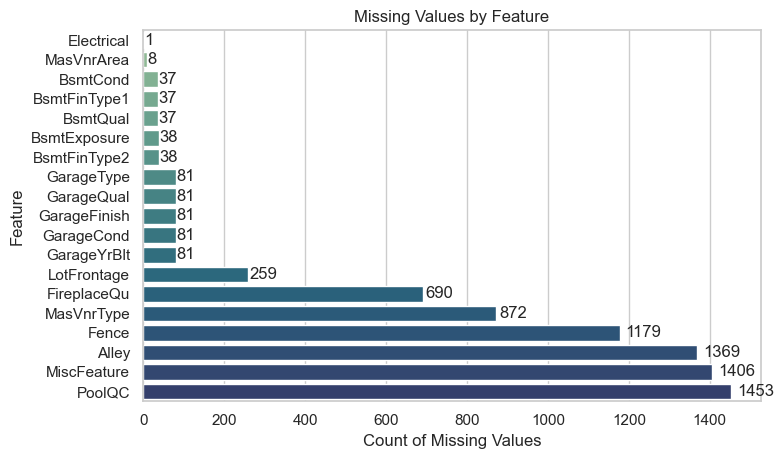

In [29]:
## Missing Values Visualization
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=True)

if missing.empty:
    print("No missing values!")
else:
    plt.figure(figsize=(8, max(4, 0.25 * len(missing))))
    sns.barplot(x=missing.values, y=missing.index, hue=missing.index, dodge=False, legend=False, palette="crest")
    plt.title("Missing Values by Feature")
    plt.xlabel("Count of Missing Values")
    plt.ylabel("Feature")
    for i, v in enumerate(missing.values):
        plt.text(v + max(1, 0.01 * v), i, str(v), va='center')
    plt.tight_layout()
    plt.show()



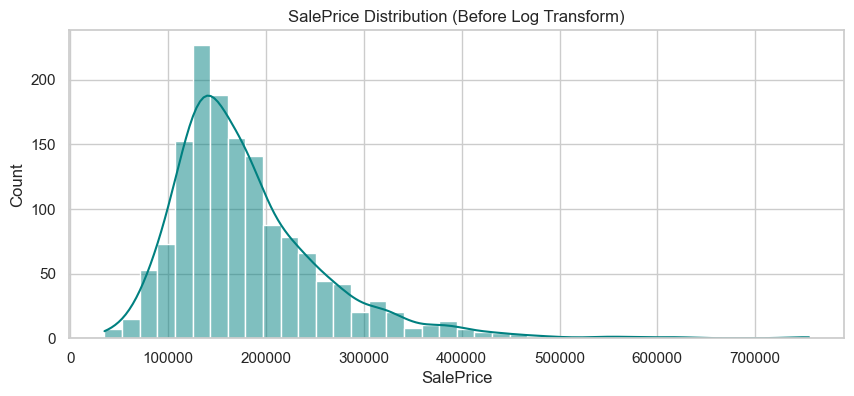

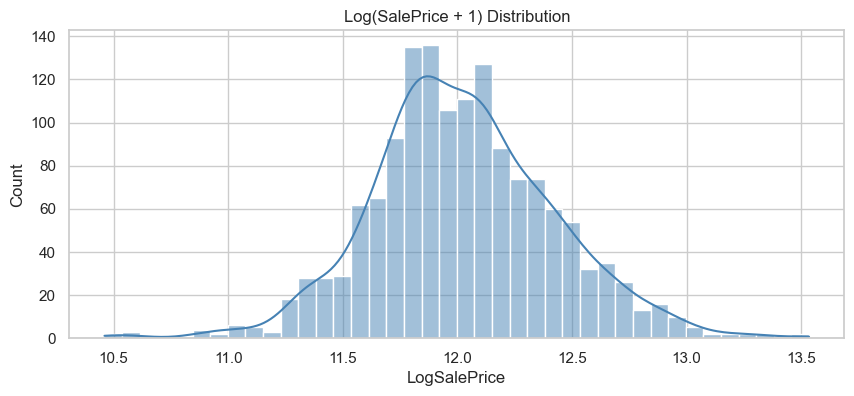

In [3]:
##  Target Variable Distribution
plt.figure(figsize=(10,4))
sns.histplot(df['SalePrice'], bins=40, kde=True, color='teal')
plt.title("SalePrice Distribution (Before Log Transform)")
plt.show()

df['LogSalePrice'] = np.log1p(df['SalePrice'])

plt.figure(figsize=(10,4))
sns.histplot(df['LogSalePrice'], bins=40, kde=True, color='steelblue')
plt.title("Log(SalePrice + 1) Distribution")
plt.show()



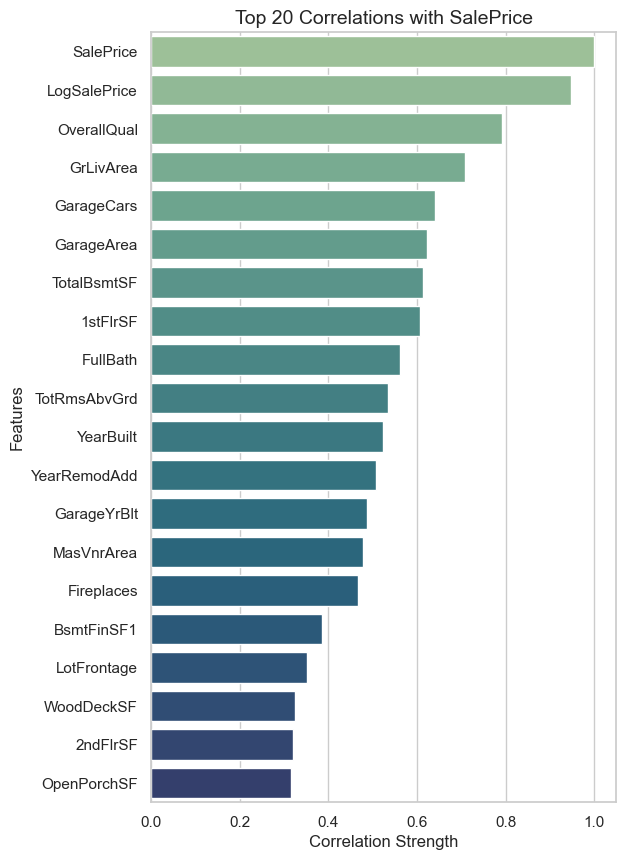

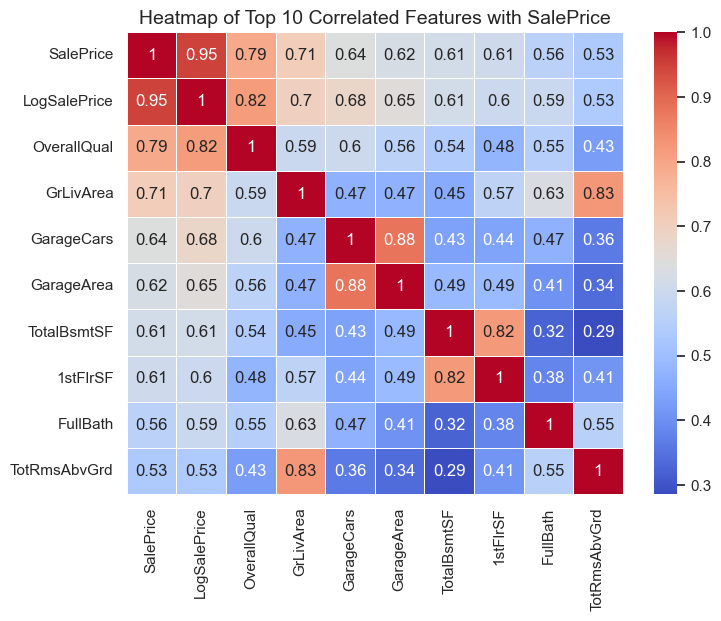

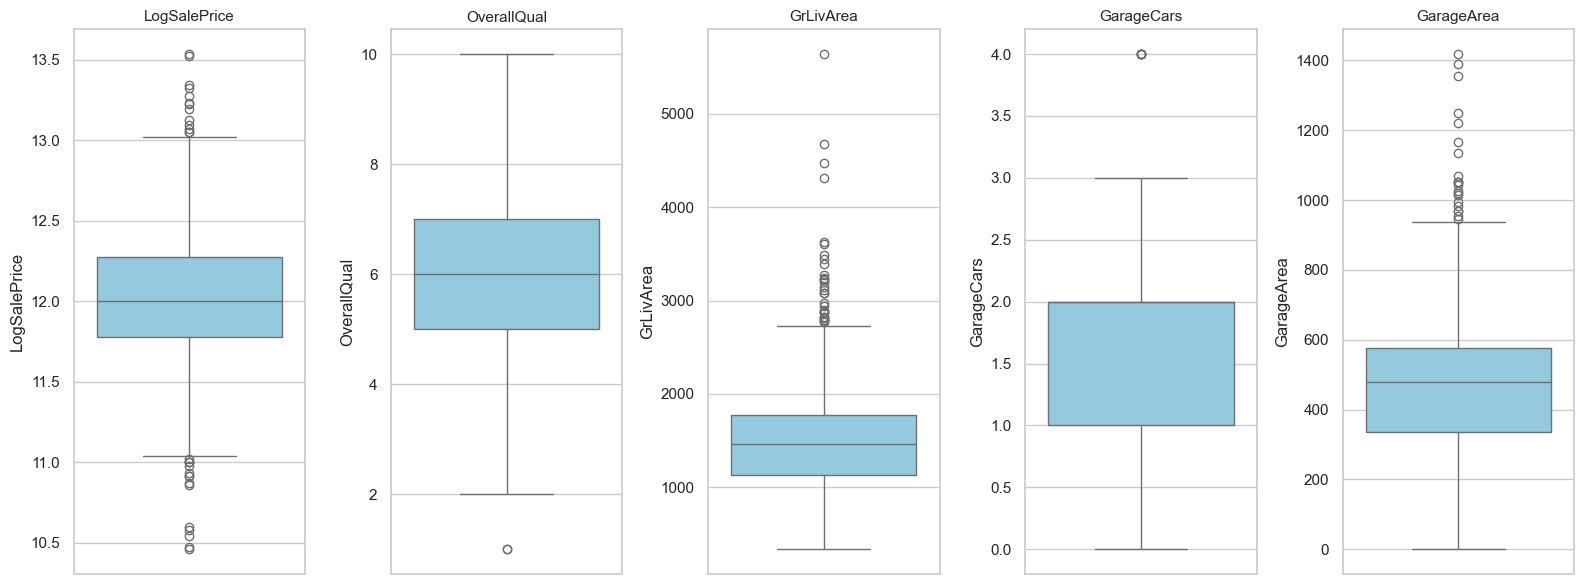

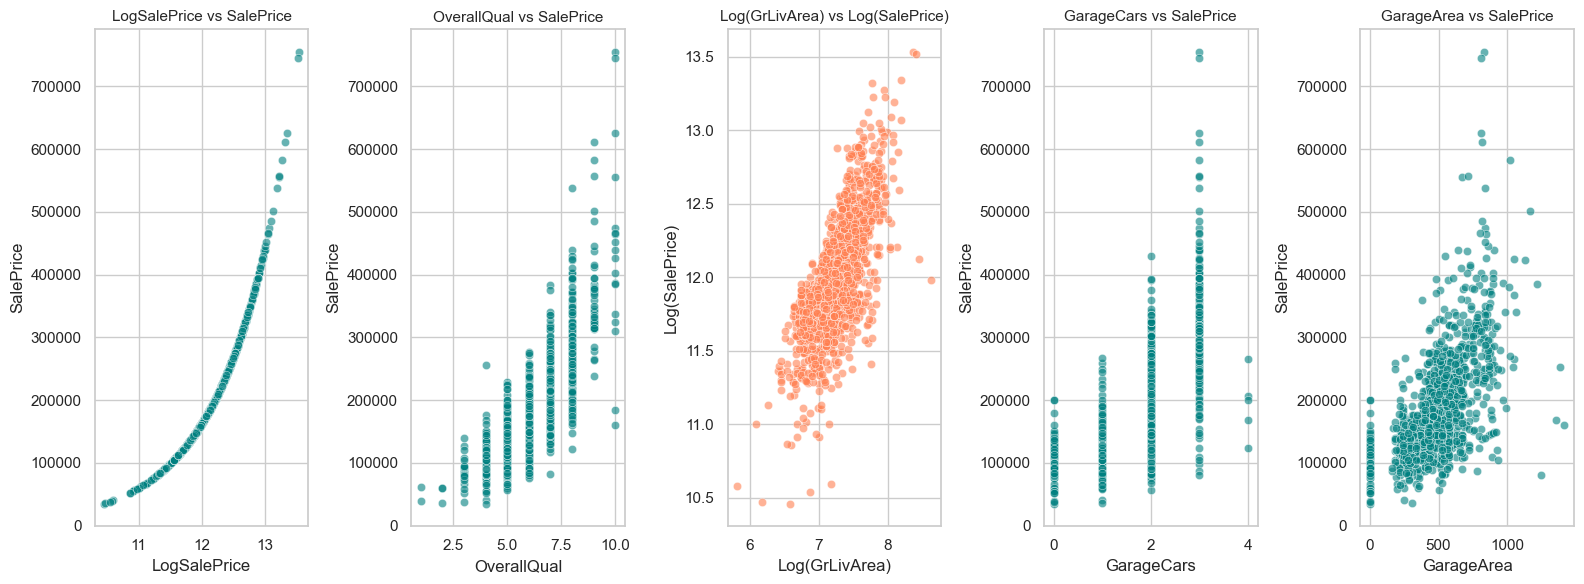

In [4]:
# ---- Correlation Analysis ----
num_df = df.select_dtypes(include=[np.number])

corr = num_df.corr()['SalePrice'].sort_values(ascending=False)

#  Top 20 Correlated Features - Barplot
plt.figure(figsize=(6,10))
sns.barplot(x=corr.values[:20], y=corr.index[:20], palette="crest")
plt.title("Top 20 Correlations with SalePrice", fontsize=14)
plt.xlabel("Correlation Strength")
plt.ylabel("Features")
plt.show()

# Heatmap for Top 10 Correlated Features
top_corr_features = corr.index[:10]
plt.figure(figsize=(8,6))
sns.heatmap(num_df[top_corr_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of Top 10 Correlated Features with SalePrice", fontsize=14)
plt.show()

# Boxplots for Top 5 Correlated Features (excluding SalePrice)
top_5 = corr.index[1:6]  # skip SalePrice itself
plt.figure(figsize=(16,6))
for i, col in enumerate(top_5, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col, fontsize=11)
plt.tight_layout()
plt.show()

# top 5 correlated features (excluding SalePrice) 
top_5 = corr.index[1:6]  # skip SalePrice itself

# Threshold to decide skewed features (e.g., skew > 1) 
skew_threshold = 1
skewed_features = num_df[top_5].skew().abs() > skew_threshold

# Scatter plots 
plt.figure(figsize=(16,6))
for i, col in enumerate(top_5, 1):
    plt.subplot(1, 5, i)
    
    # If feature is skewed, log-transform both x and y
    if skewed_features[col]:
        sns.scatterplot(x=np.log1p(df[col]), y=np.log1p(df['SalePrice']), alpha=0.6, color='coral')
        plt.xlabel(f'Log({col})')
        plt.ylabel('Log(SalePrice)')
        plt.title(f'Log({col}) vs Log(SalePrice)', fontsize=11)
    else:
        sns.scatterplot(x=df[col], y=df['SalePrice'], alpha=0.6, color='teal')
        plt.xlabel(col)
        plt.ylabel('SalePrice')
        plt.title(f'{col} vs SalePrice', fontsize=11)
        
plt.tight_layout()
plt.show()





In [5]:
##  Categorical Variable Exploration (Interactive)
cat_df = df.select_dtypes(include=['object']).columns.tolist()

@interact(feature=Dropdown(options=cat_df, description="Category"))
def plot_categorical(feature):
    plt.figure(figsize=(8,4))
    sns.boxplot(x=feature, y='SalePrice', data=df, palette="crest")
    plt.title(f"SalePrice vs {feature}")
    plt.xticks(rotation=45)
    plt.show()


interactive(children=(Dropdown(description='Category', options=('MSZoning', 'Street', 'Alley', 'LotShape', 'La…

In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
##  Feature Engineering & Preprocessing
print("---Performing feature engineering---")

df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['HasPool'] = np.where(df['PoolArea'] > 0, 1, 0)
df['HasGarage'] = np.where(df['GarageArea'] > 0, 1, 0)
df['HasFireplace'] = np.where(df['Fireplaces'] > 0, 1, 0)

if 'OverallQual' in df.columns:
    df['QualityCategory'] = pd.cut(df['OverallQual'],
                                   bins=[0,4,6,8,10],
                                   labels=['Low','Medium','Good','Excellent'])
print(f"----Feature Engineering Complete-----\nShape: {df.shape}")

X = df.drop(['SalePrice', 'LogSalePrice'], axis=1)
y = df['LogSalePrice']

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Test Split Done:", X_train.shape, X_test.shape)


---Performing feature engineering---
----Feature Engineering Complete-----
Shape: (1460, 90)
Train/Test Split Done: (1168, 88) (292, 88)


In [9]:
## Baseline Model Comparison (with Stacking Regressor)
# Base models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42,n_jobs=1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42,),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0,n_jobs=1),
    'LightGBM': LGBMRegressor(random_state=42,n_jobs=1),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}


# --- Stacking Regressor ---
base_learners = [
    ('rf', RandomForestRegressor(random_state=42, n_jobs=1)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, verbosity=0, n_jobs=1))
]
meta_model = Ridge()
stacking = StackingRegressor(estimators=base_learners, final_estimator=meta_model, n_jobs=1)
models['StackingRegressor'] = stacking

# --- Model Evaluation ---
results = []

for name, model in models.items():
    try:
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results.append((name, r2, mse, rmse, mae))
    except Exception as e:
        print(f"X {name} failed: {e}")

# --- Results Summary ---
results_df = (
    pd.DataFrame(results, columns=['Model', 'R2', 'MSE', 'RMSE', 'MAE'])
    .sort_values(by='R2', ascending=False)
)

print("\n Model Performance Comparison:")
display(results_df.style.background_gradient(cmap='coolwarm', subset=['R2']))



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3894
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 185
[LightGBM] [Info] Start training from score 12.030658

 Model Performance Comparison:


,Model,R2,MSE,RMSE,MAE
0,LinearRegression,0.906075,0.017527,0.132391,0.090306
1,Ridge,0.905219,0.017687,0.132993,0.090297
9,StackingRegressor,0.905134,0.017703,0.133053,0.087829
5,GradientBoosting,0.903915,0.017931,0.133905,0.089687
7,LightGBM,0.895647,0.019473,0.139547,0.088754
6,XGBoost,0.888806,0.020750,0.144049,0.097241
4,RandomForest,0.881587,0.022097,0.148651,0.099595
8,DecisionTree,0.762682,0.044286,0.210443,0.146994
2,Lasso,-0.005837,0.187700,0.433244,0.337134
3,ElasticNet,-0.005837,0.187700,0.433244,0.337134


✅ Ridge Tuned Parameters: {'model__alpha': np.float64(14.649878836228101)}
✅ Lasso Tuned Parameters: {'model__alpha': np.float64(0.0016599452033620266)}
✅ ElasticNet Tuned Parameters: {'model__alpha': np.float64(0.0031461376917337066), 'model__l1_ratio': np.float64(0.1879049026057455)}
✅ XGBoost Tuned Parameters: {'model__colsample_bytree': np.float64(0.9312901539863683), 'model__learning_rate': np.float64(0.10875911927287815), 'model__max_depth': 3, 'model__n_estimators': 306, 'model__subsample': np.float64(0.8282623055075649)}
✅ Stacking Model Trained Successfully


,Model,MSE,RMSE,MAE,R2
2,ElasticNet (Tuned),5.927497e+08,24346.452275,15890.778044,0.922722
0,Ridge (Tuned),6.105716e+08,24709.746746,16134.141083,0.920398
1,Lasso (Tuned),6.867765e+08,26206.421877,16729.726951,0.910463
3,XGBoost (Tuned),7.839145e+08,27998.472880,15648.399789,0.897799
4,Stacking (Tuned),1.309003e+09,36180.145969,16741.699852,0.829342


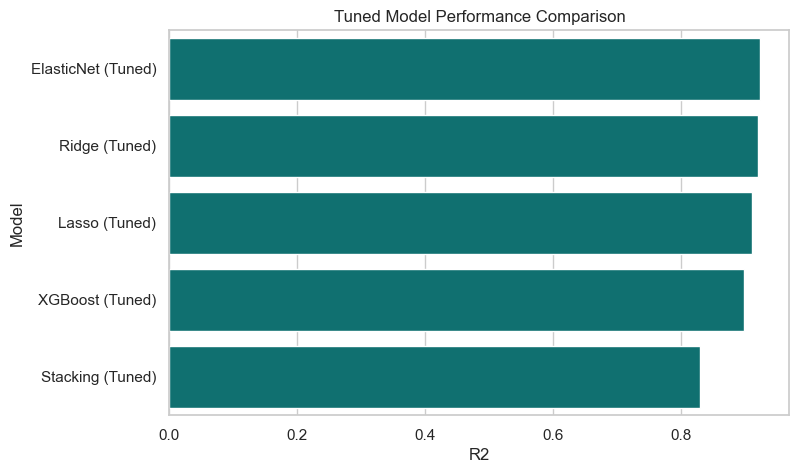

In [11]:

#  Model Tuning
tuned_results = []

# Ridge
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
ridge_params = {'model__alpha': uniform(0.01, 20)}
ridge_search = RandomizedSearchCV(ridge_pipe, ridge_params, n_iter=20, scoring='r2', cv=5, n_jobs=-1, random_state=42)
ridge_search.fit(X_train, y_train)
best_ridge = ridge_search.best_estimator_
y_pred_ridge = np.expm1(best_ridge.predict(X_test))
tuned_results.append(['Ridge (Tuned)',
    mean_squared_error(np.expm1(y_test), y_pred_ridge),
    np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_ridge)),
    mean_absolute_error(np.expm1(y_test), y_pred_ridge),
    r2_score(np.expm1(y_test), y_pred_ridge)
])
print("✅ Ridge Tuned Parameters:", ridge_search.best_params_)

# Lasso
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=5000))
])
lasso_params = {'model__alpha': uniform(0.0001, 0.01)}
lasso_search = RandomizedSearchCV(lasso_pipe, lasso_params, n_iter=20, scoring='r2', cv=5, n_jobs=-1, random_state=42)
lasso_search.fit(X_train, y_train)
best_lasso = lasso_search.best_estimator_
y_pred_lasso = np.expm1(best_lasso.predict(X_test))
tuned_results.append(['Lasso (Tuned)',
    mean_squared_error(np.expm1(y_test), y_pred_lasso),
    np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_lasso)),
    mean_absolute_error(np.expm1(y_test), y_pred_lasso),
    r2_score(np.expm1(y_test), y_pred_lasso)
])
print("✅ Lasso Tuned Parameters:", lasso_search.best_params_)

# ElasticNet
enet_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet(max_iter=5000))
])
enet_params = {'model__alpha': uniform(0.0001, 0.01), 'model__l1_ratio': uniform(0.1, 0.9)}
enet_search = RandomizedSearchCV(enet_pipe, enet_params, n_iter=20, scoring='r2', cv=5, n_jobs=-1, random_state=42)
enet_search.fit(X_train, y_train)
best_enet = enet_search.best_estimator_
y_pred_enet = np.expm1(best_enet.predict(X_test))
tuned_results.append(['ElasticNet (Tuned)',
    mean_squared_error(np.expm1(y_test), y_pred_enet),
    np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_enet)),
    mean_absolute_error(np.expm1(y_test), y_pred_enet),
    r2_score(np.expm1(y_test), y_pred_enet)
])
print("✅ ElasticNet Tuned Parameters:", enet_search.best_params_)

# XGBoost
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])
xgb_params = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.7, 0.3)
}
xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=25, scoring='r2', cv=5, n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
y_pred_xgb = np.expm1(best_xgb.predict(X_test))
tuned_results.append(['XGBoost (Tuned)',
    mean_squared_error(np.expm1(y_test), y_pred_xgb),
    np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_xgb)),
    mean_absolute_error(np.expm1(y_test), y_pred_xgb),
    r2_score(np.expm1(y_test), y_pred_xgb)
])
print("✅ XGBoost Tuned Parameters:", xgb_search.best_params_)

# 7️⃣ Stacking (Tuned)
stack_tuned = StackingRegressor(
    estimators=[('ridge', best_ridge.named_steps['model']), ('xgb', best_xgb.named_steps['model'])],
    final_estimator=GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    n_jobs=-1
)
stack_pipe = Pipeline([('preprocessor', preprocessor), ('model', stack_tuned)])
stack_pipe.fit(X_train, y_train)
y_pred_stack = np.expm1(stack_pipe.predict(X_test))
tuned_results.append(['Stacking (Tuned)',
    mean_squared_error(np.expm1(y_test), y_pred_stack),
    np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_stack)),
    mean_absolute_error(np.expm1(y_test), y_pred_stack),
    r2_score(np.expm1(y_test), y_pred_stack)
])
print("✅ Stacking Model Trained Successfully")

# 8️⃣ Comparison
tuned_df = pd.DataFrame(tuned_results, columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2']).sort_values('R2', ascending=False)
display(tuned_df)

plt.figure(figsize=(8,5))
sns.barplot(data=tuned_df, x='R2', y='Model', color='teal')
plt.title('Tuned Model Performance Comparison')
plt.show()

In [12]:

#  CROSS VALIDATION FOR ELASTICNET (TUNED)
cv_scores = cross_val_score(best_enet, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

print(" Cross Validation R² Scores:", np.round(cv_scores, 4))
print("Mean CV R²:", np.mean(cv_scores).round(4))
print("Std Deviation:", np.std(cv_scores).round(4))


 Cross Validation R² Scores: [0.8876 0.8446 0.7792 0.9144 0.888 ]
Mean CV R²: 0.8628
Std Deviation: 0.0474


In [13]:

#  Feature Importance for ElasticNet (Tuned)

# Get feature names after preprocessing
num_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)
cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Get coefficients from tuned ElasticNet
elasticnet_model = best_enet.named_steps['model']
coef = elasticnet_model.coef_

# Combine into DataFrame
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coef,
    'AbsCoeff': np.abs(coef)
}).sort_values(by='AbsCoeff', ascending=False)

# Display top 15
top_features = feature_importance.head(15)
display(top_features)

##plot top n features interactively
top_features_sorted = top_features.sort_values('AbsCoeff', ascending=False)

def plot_top_features(n=10):
    clear_output(wait=True)
    
    subset = top_features_sorted.head(n).sort_values('AbsCoeff', ascending=True)  # horizontal bar
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='AbsCoeff', y='Feature', data=subset, palette='magma')
    plt.xlabel("Absolute Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Top {n} Most Influential Features — ElasticNet (Tuned)")
    plt.tight_layout()
    plt.show()

# Slider widget to choose number of features
widgets.interact(plot_top_features, n=widgets.IntSlider(min=5, max=15, step=1, value=10))




,Feature,Coefficient,AbsCoeff
41,HasPool,-0.127536,0.127536
132,RoofMatl_ClyTile,-0.119847,0.119847
33,PoolArea,0.117450,0.117450
109,Condition2_PosN,-0.100959,0.100959
93,Neighborhood_StoneBr,0.092694,0.092694
77,Neighborhood_Crawfor,0.090451,0.090451
16,GrLivArea,0.086981,0.086981
142,Exterior1st_BrkFace,0.084069,0.084069
4,OverallQual,0.080290,0.080290
269,PoolQC_Gd,-0.077253,0.077253


interactive(children=(IntSlider(value=10, description='n', max=15, min=5), Output()), _dom_classes=('widget-in…

<function __main__.plot_top_features(n=10)>


Running SHAP analysis for ElasticNet (Tuned)...


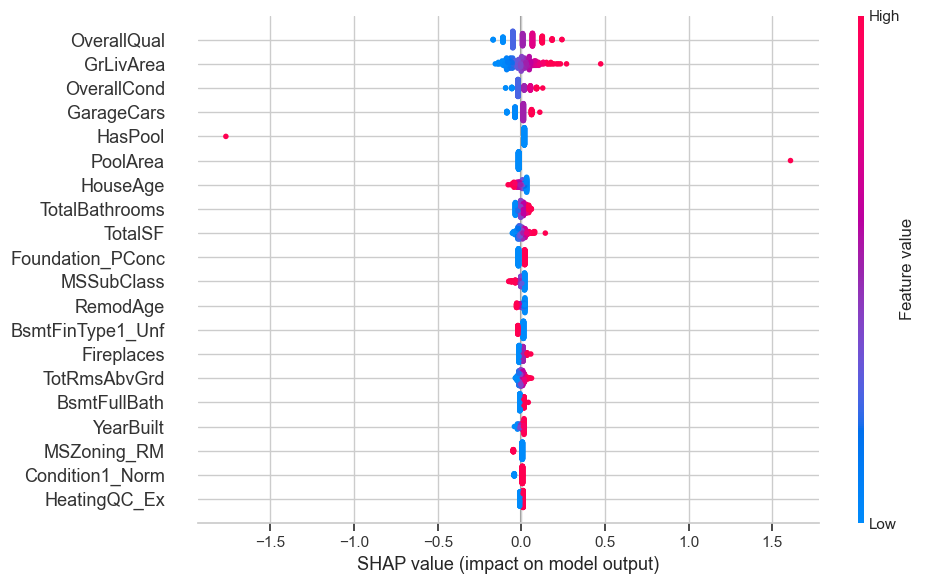

In [18]:
print("\nRunning SHAP analysis for ElasticNet (Tuned)...")

# Sample rows for SHAP speed
X_sample = X_test.sample(200, random_state=42)

# ---- Transform data through preprocessing ----
X_sample_transformed = best_enet.named_steps['preprocessor'].transform(X_sample)

# Convert sparse → dense (required for ElasticNet + SHAP)
if hasattr(X_sample_transformed, "toarray"):
    X_dense = X_sample_transformed.toarray()
else:
    X_dense = X_sample_transformed

# ---- Extract ElasticNet model ----
model = best_enet.named_steps['model']

# ---- SHAP for linear models ----
explainer = shap.LinearExplainer(model, X_dense)
shap_values = explainer(X_dense)

# ---- Build feature name list ----
# numeric columns
feature_names = list(num_cols)

# categorical one-hot columns
onehot_names = (
    best_enet.named_steps['preprocessor']
    .named_transformers_['cat']['encoder']
    .get_feature_names_out(cat_cols)
)
feature_names.extend(onehot_names)

# ---- Create DataFrame with all transformed features ----
X_trans_df = pd.DataFrame(X_dense, columns=feature_names)

# ---- SHAP summary plot ----
shap.summary_plot(
    shap_values.values,   # SHAP values matrix
    X_trans_df,           # feature values
    feature_names=feature_names,
    plot_size=(10, 6)
)


In [19]:

## Customer Recommendations 

#  Neighborhood Analysis 
neighborhood_analysis = df.groupby('Neighborhood').agg({
    'SalePrice': ['mean', 'median', 'count'],
    'GrLivArea': 'mean',
    'OverallQual': 'mean'
}).round(2)
neighborhood_analysis.columns = ['Avg_Price', 'Median_Price', 'Count', 'Avg_LivArea', 'Avg_Quality']
neighborhood_analysis = neighborhood_analysis.sort_values('Avg_Price', ascending=False)

print("Top 10 Premium Neighborhoods:")
display(neighborhood_analysis.head(10))

print("Top 10 Affordable Neighborhoods:")
display(neighborhood_analysis.tail(10))

# Price per sq ft & value score
df['PricePerSqFt'] = df['SalePrice'] / df['GrLivArea']
value_analysis = df.groupby('Neighborhood').agg({
    'PricePerSqFt': 'mean',
    'SalePrice': 'mean',
    'OverallQual': 'mean',
    'GrLivArea': 'mean'
}).round(2)
value_analysis['Value_Score'] = (value_analysis['OverallQual'] / value_analysis['PricePerSqFt'] * 100).round(2)
value_analysis = value_analysis.sort_values('Value_Score', ascending=False)

print("Top 10 Best Value Neighborhoods:")
display(value_analysis.head(10))



Top 10 Premium Neighborhoods:


,Avg_Price,Median_Price,Count,Avg_LivArea,Avg_Quality
Neighborhood,,,,,
NoRidge,335295.32,301500.0,41,2508.85,7.93
NridgHt,316270.62,315000.0,77,1915.95,8.26
StoneBr,310499.00,278000.0,25,1879.08,8.16
Timber,242247.45,228475.0,38,1749.37,7.16
Veenker,238772.73,218000.0,11,1539.64,6.73
Somerst,225379.84,225500.0,86,1596.65,7.34
ClearCr,212565.43,200250.0,28,1788.11,5.89
Crawfor,210624.73,200624.0,51,1791.61,6.27
CollgCr,197965.77,197200.0,150,1480.50,6.64


Top 10 Affordable Neighborhoods:


,Avg_Price,Median_Price,Count,Avg_LivArea,Avg_Quality
Neighborhood,,,,,
NPkVill,142694.44,146000.0,9,1253.00,6.00
SWISU,142591.36,139500.0,25,1801.24,5.44
Blueste,137500.00,137500.0,2,1392.50,6.00
Sawyer,136793.14,135000.0,74,1215.14,5.03
OldTown,128225.30,119000.0,113,1479.73,5.39
Edwards,128219.70,121750.0,100,1340.04,5.08
BrkSide,124834.05,124300.0,58,1203.07,5.05
BrDale,104493.75,106000.0,16,1143.19,5.69
IDOTRR,100123.78,103000.0,37,1142.30,4.76


Top 10 Best Value Neighborhoods:


,PricePerSqFt,SalePrice,OverallQual,GrLivArea,Value_Score
Neighborhood,,,,,
SWISU,84.76,142591.36,5.44,1801.24,6.42
BrDale,91.95,104493.75,5.69,1143.19,6.19
Blueste,98.97,137500.00,6.00,1392.50,6.06
NoRidge,132.27,335295.32,7.93,2508.85,6.00
OldTown,91.43,128225.30,5.39,1479.73,5.90
NWAmes,111.85,189050.07,6.33,1727.78,5.66
Gilbert,119.11,192854.51,6.56,1641.32,5.51
IDOTRR,89.14,100123.78,4.76,1142.30,5.34
SawyerW,119.70,186555.80,6.32,1595.02,5.28


In [20]:
def predict_house(overall_qual=5, gr_liv_area=1500, garage_cars=2, total_bsmt_sf=800, year_built=2000):
    input_data = {
        'OverallQual': [overall_qual],
        'GrLivArea': [gr_liv_area],
        'GarageCars': [garage_cars],
        'TotalBsmtSF': [total_bsmt_sf],
        'YearBuilt': [year_built],
    }
    input_df = pd.DataFrame(input_data)
    
    # Fill missing columns
    for col in X_train.columns:
        if col not in input_df.columns:
            input_df[col] = 0

    # Predict log price and convert back
    pred_log = best_enet.predict(input_df)[0]
    pred_price = np.expm1(pred_log)

    print(f"Predicted Sale Price: ${pred_price:,.0f}")

widgets.interact(
    predict_house,
    overall_qual=widgets.IntSlider(min=1, max=10, step=1, value=5),
    gr_liv_area=widgets.IntSlider(min=500, max=4000, step=100, value=1500),
    garage_cars=widgets.IntSlider(min=0, max=4, step=1, value=2),
    total_bsmt_sf=widgets.IntSlider(min=0, max=2000, step=50, value=800),
    year_built=widgets.IntSlider(min=1900, max=2020, step=5, value=2000)
)


interactive(children=(IntSlider(value=5, description='overall_qual', max=10, min=1), IntSlider(value=1500, des…

<function __main__.predict_house(overall_qual=5, gr_liv_area=1500, garage_cars=2, total_bsmt_sf=800, year_built=2000)>

In [21]:
#House recommendations
# Predict prices for all houses
df['PredictedPrice'] = np.expm1(best_enet.predict(X))
df['DiffPercent'] = ((df['PredictedPrice'] - df['SalePrice']) / df['SalePrice']) * 100

# Filter undervalued houses
best_deals = df[(df['DiffPercent'] > 10) & (df['OverallQual'] >= 6)].sort_values('DiffPercent', ascending=False)

# Display top 10 deals
display(best_deals[['Neighborhood','OverallQual','GrLivArea','SalePrice','PredictedPrice','DiffPercent']].head(10))


,Neighborhood,OverallQual,GrLivArea,SalePrice,PredictedPrice,DiffPercent
523,Edwards,10,4676,184750,564499.087392,205.547544
1298,Edwards,10,5642,160000,456376.208881,185.235131
632,NWAmes,7,1411,82500,169386.462179,105.316924
1324,Somerst,8,1795,147000,271570.978967,84.742163
714,Sawyer,6,1479,130500,175948.852062,34.826707
666,NAmes,6,2380,129000,169680.638273,31.535379
581,NridgHt,8,2042,253293,324840.979580,28.247121
3,Crawfor,7,1717,140000,177706.474211,26.933196
318,NoRidge,7,2646,260000,326261.299337,25.485115
93,OldTown,6,2291,133900,167581.309951,25.154078


In [22]:
def recommend_houses(max_price=300000, min_quality=5, neighborhood='All'):
    filtered = df.copy()
    
    if neighborhood != 'All':
        filtered = filtered[filtered['Neighborhood'] == neighborhood]
    
    filtered = filtered[(filtered['SalePrice'] <= max_price) & (filtered['OverallQual'] >= min_quality)]
    
    # Recalculate predicted prices and differences
    filtered['PredictedPrice'] = np.expm1(best_enet.predict(filtered[X.columns]))
    filtered['DiffPercent'] = ((filtered['PredictedPrice'] - filtered['SalePrice']) / filtered['SalePrice']) * 100
    
    top5 = filtered.sort_values('DiffPercent', ascending=False).head(5)
    
    display(top5[['Neighborhood','OverallQual','GrLivArea','SalePrice','PredictedPrice','DiffPercent']])

widgets.interact(
    recommend_houses,
    max_price=widgets.IntSlider(min=50000, max=600000, step=50000, value=300000),
    min_quality=widgets.IntSlider(min=1, max=10, step=1, value=5),
    neighborhood=widgets.Dropdown(options=['All'] + list(df['Neighborhood'].unique()), value='All')
)


interactive(children=(IntSlider(value=300000, description='max_price', max=600000, min=50000, step=50000), Int…

<function __main__.recommend_houses(max_price=300000, min_quality=5, neighborhood='All')>

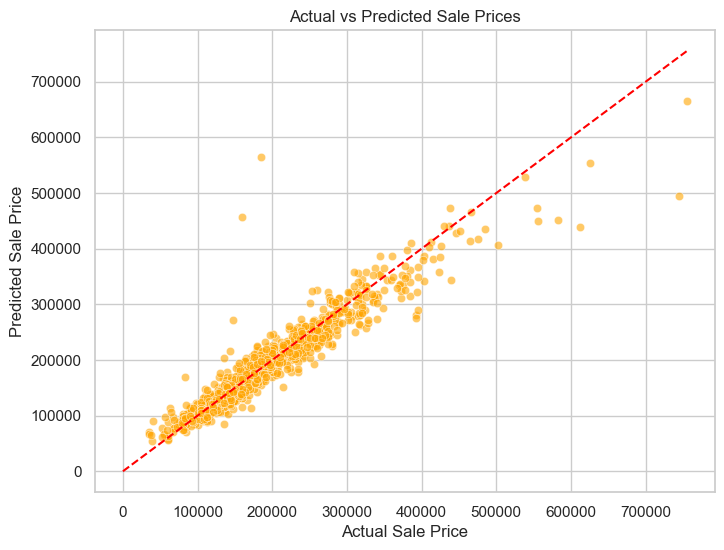

In [23]:
#Actual vs predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x='SalePrice', y='PredictedPrice', data=df, color='orange', alpha=0.6)
plt.plot([0, df['SalePrice'].max()],[0, df['SalePrice'].max()],'r--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

In [24]:
import joblib

# Save pipeline
joblib.dump(best_enet, "best_pipeline.joblib")
print("Saved pipeline to best_pipeline.joblib")

# Save data with predictions
df.to_csv("house_data_with_predictions.csv", index=False)
print("Saved house_data_with_predictions.csv")

# Save top deals
best_deals.to_csv("best_deals.csv", index=False)
print(f"Saved {len(best_deals)} best deals to best_deals.csv")


Saved pipeline to best_pipeline.joblib
Saved house_data_with_predictions.csv
Saved 109 best deals to best_deals.csv
